In [1]:
%load_ext rpy2.ipython

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import math
import random

import scipy.stats as stats

from scipy.stats import fit
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import fisher_exact
from scipy.stats import zscore
from scipy.stats import percentileofscore
from statsmodels.stats.multitest import multipletests # for fdr
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import wilcoxon





In [2]:
%%R

library(dplyr)
library(ggplot2)
library(readr)
library(stringr)
library(scales)
library(data.table)
library(grid)


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘scales’


R[write to console]: The following object is masked from ‘package:readr’:

    col_factor


R[write to console]: data.table 1.16.2 using 12 threads (see ?getDTthreads).  
R[write to console]: Latest news: r-datatable.com

R[write to console]: 
Attaching package: ‘data.table’


R[write to console]: The following objects are masked from ‘package:dplyr’:

    between, first, last




Enrichment lollypop plot

In [3]:
%%R
human     <- fread("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/multi_species_analysis/Human/Human_nuno_plot_data.tsv")
rhesus    <- fread("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/multi_species_analysis/rheMac/rhesus_plot_data_new.tsv")
chimp     <- fread("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/multi_species_analysis/Chimp/Chimp_plot_data.tsv")
orangutan <- fread("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/multi_species_analysis/Orangutan/orangutan_plot_data.tsv")


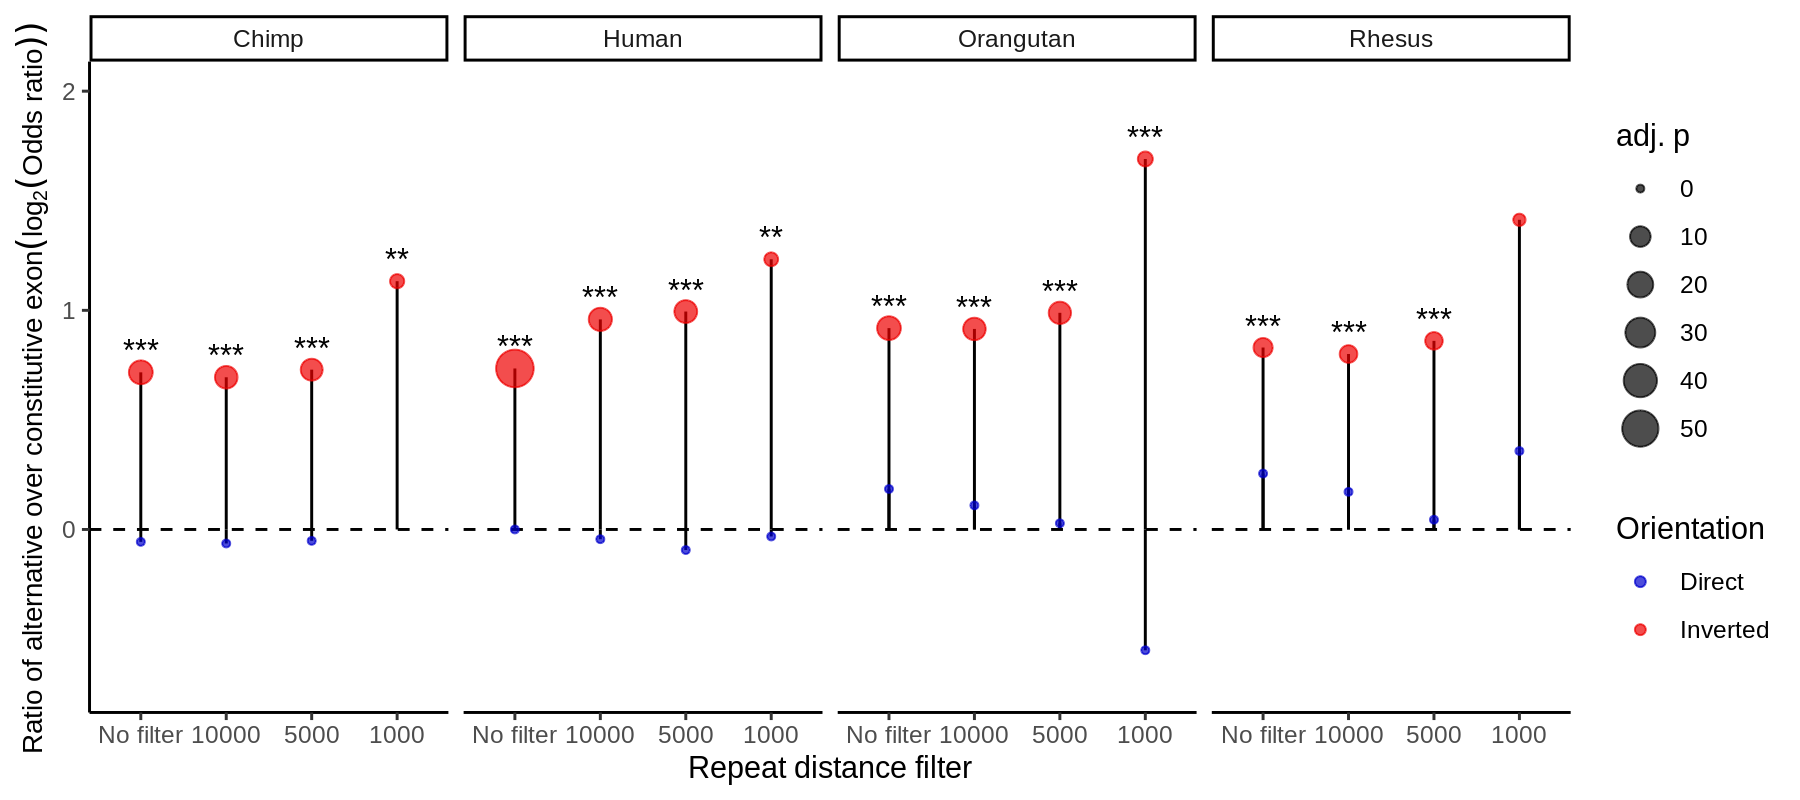

In [4]:
%%R -w 9 -h 4 --units in -r 200

# 2. Add a 'species' column to each dataset
human[, species := "Human"]
rhesus[, species := "Rhesus"]
chimp[, species := "Chimp"]
orangutan[, species := "Orangutan"]

# 3. Combine all data into one data.table
all_data <- rbind(human, rhesus, chimp, orangutan, fill = TRUE)

# 4. Compute Bonferroni-adjusted p-values (assuming each dataset has a column 'P_Value')
all_data[, adj_p_val := p.adjust(P_Value, method = "bonferroni")]

# 5. Create significance labels based on adj_p_val
all_data[, significance := cut(adj_p_val,
                                 breaks = c(0, 0.001, 0.01, 0.05, 1),
                                 labels = c("***", "**", "*", "ns"))]

# 6. Ensure Dist_threshold is a factor with the desired order
all_data[, Dist_threshold := factor(Dist_threshold,
                                     levels = c("No filter", "10000", "5000", "1000"))]

# 7. Create the plot with facet_wrap to display all species side by side
multi_species_plot <- ggplot(all_data, aes(x = Dist_threshold, y = log2(Odds_Ratio))) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
  geom_segment(aes(x = Dist_threshold, xend = Dist_threshold, 
                   y = 0, yend = log2(Odds_Ratio)),
               color = "black", size = 0.5) +
  geom_point(aes(colour = Type, size = -log10(adj_p_val)), alpha = 0.7) +
  geom_text(data = subset(all_data, significance != "ns"),
            aes(label = significance),
            vjust = -0.5) +
  facet_wrap(~ species, nrow = 1) +
  xlab("Repeat distance filter") +
  ylab(expression("Ratio of alternative over constitutive exon" * (log[2]("Odds ratio")))) +
  ylim(c(-0.7, 2)) +
  scale_colour_manual(name = "Orientation",
                      values = c("Direct" = "blue3", "Inverted" = "red2")) +
  scale_size_continuous(name = "adj. p") +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5),
        axis.title.y = element_text(size = 10))

print(multi_species_plot)


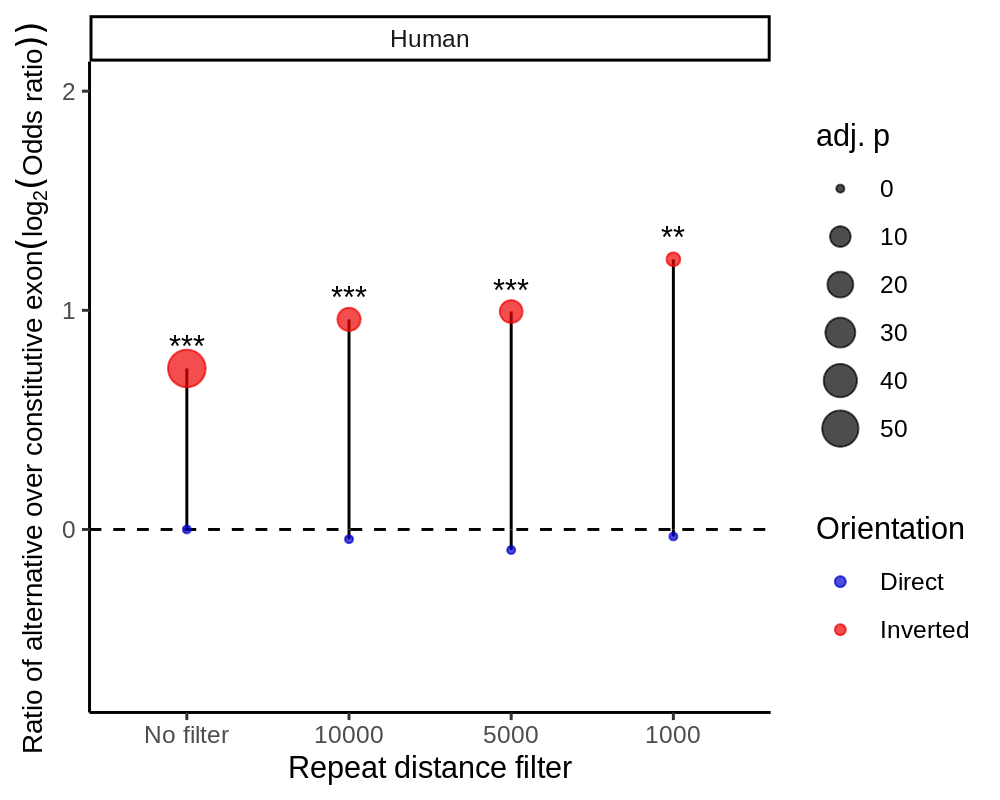

In [5]:
%%R -w 5 -h 4 --units in -r 200

#Figure 1B

# Filter for Human species only
human_data <- all_data[species == "Human"]

# Create the plot with facet_wrap to retain the "Human" label
human_plot <- ggplot(human_data, aes(x = Dist_threshold, y = log2(Odds_Ratio))) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
  geom_segment(aes(x = Dist_threshold, xend = Dist_threshold, 
                   y = 0, yend = log2(Odds_Ratio)),
               color = "black", size = 0.5) +
  geom_point(aes(colour = Type, size = -log10(adj_p_val)), alpha = 0.7) +
  geom_text(data = subset(human_data, significance != "ns"),
            aes(label = significance),
            vjust = -0.5) +
  facet_wrap(~ species, nrow = 1) +  # This retains the "Human" label
  xlab("Repeat distance filter") +
  ylab(expression("Ratio of alternative over constitutive exon" * (log[2]("Odds ratio")))) +
  ylim(c(-0.7, 2)) +
  scale_colour_manual(name = "Orientation",
                      values = c("Direct" = "blue3", "Inverted" = "red2")) +
  scale_size_continuous(name = "adj. p") +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5),
        axis.title.y = element_text(size = 10))

print(human_plot)


Negative control randomization

In [22]:
%%R

random_Alu_data <- fread("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/human_analysis/randomize_Alu_negative_control/Negative_control_data.tsv")

random_Alu_data[ , adj_p_val:=p.adjust(P_Value, method = "bonferroni")]


       Type Dist_threshold Odds_Ratio    P_Value adj_p_val
     <char>         <char>      <num>      <num>     <num>
1:   Direct      No filter   1.119976 0.08056414 0.1611283
2: Inverted      No filter   1.115966 0.11669433 0.2333887


In [23]:
%%R


random_Alu_data$significance <- cut(random_Alu_data$adj_p_val,
                                         breaks = c(0, 0.001, 0.01, 0.05, 1),
                                         labels = c("***", "**", "*", "ns"))


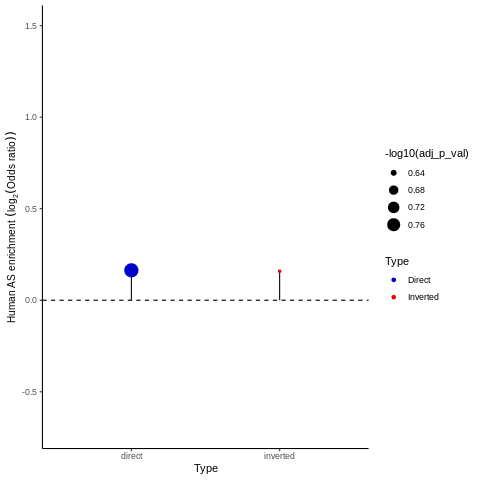

In [ ]:
%%R
#Fig 2B

random_alu_plot <- ggplot(random_Alu_data) +
    geom_hline(yintercept=0, linetype="dashed", color="black") +  
    geom_segment(aes(x=Type, xend=Type, y=0, yend=log2(Odds_Ratio)), color="black") +  
    geom_point(aes(x=Type, y=log2(Odds_Ratio), group=Type, colour=Type, size=-log10(adj_p_val))) +  
    geom_text(data = subset(random_Alu_data, significance != 'ns'),
              aes(x=Type, y=log2(Odds_Ratio), label=significance),
              vjust=-0.5) +  
    xlab('Type') +  
    ylab(expression("Human AS enrichment " * (log[2]("Odds ratio")))) +
    ylim(c(-0.7, 1.5)) +
    scale_x_discrete(labels = c("Direct" = "direct", "Inverted" = "inverted")) +  
    scale_colour_manual(values = c("blue3", "red2")) +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5), axis.title.y = element_text(size = 10))

random_alu_plot

In [27]:
%%R

Fig1E_repeat_types <- fread("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/figure_for_paper/Plot_data_from_Yue/SPLASH_plots/fig_raw_data/Fig2_Alu_pair_types.txt")


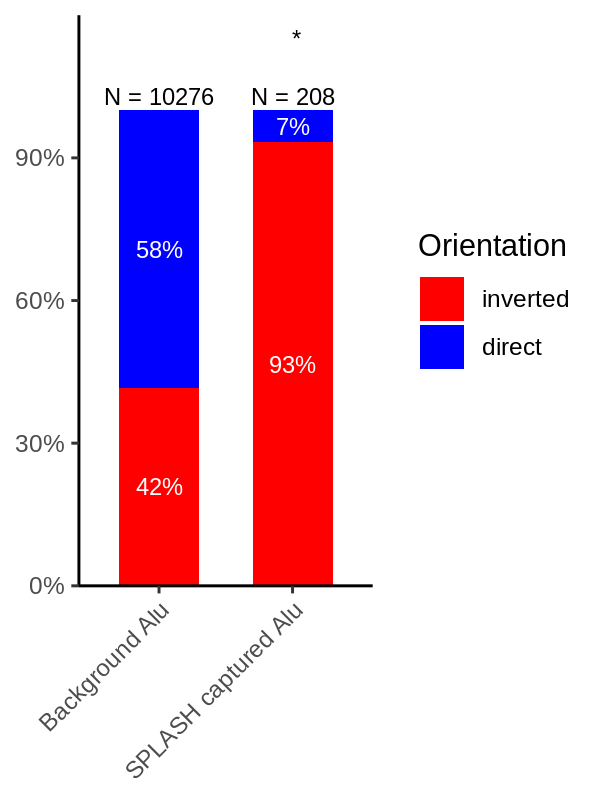

In [ ]:
%%R -w 3 -h 4 --units in -r 200

#Fig1E

Fig1E_repeat_types[, orientation := type_meta]

# Assign the data to data_sub.
data_sub <- Fig1E_repeat_types

# (Re)calculate totals and percentages if needed.
data_sub[, total := sum(count), by = group]
data_sub[, perc := count / total]

contingency_table <- matrix(
  c(4277, 5999,   # Background_Alu: [inverted, direct]
    194,  14),    # SPLASH_captured_Alu: [inverted, direct]
  nrow = 2, byrow = TRUE
)
rownames(contingency_table) <- c("Background_Alu", "SPLASH_captured_Alu")
colnames(contingency_table) <- c("inverted", "direct")
fisher_result <- fisher.test(contingency_table)
p_value <- fisher_result$p.value
sig_label <- ifelse(p_value < 0.05, "*", "ns")

# Prepare a data frame of totals for annotation.
totals <- unique(data_sub[, .(group, total)])

# Create the proportional stacked bar plot.
p2 <- ggplot(data_sub, aes(x = group, y = perc, fill = orientation)) +
  geom_bar(stat = "identity", position = "fill", width = 0.6) +
  # Rename the legend to 'Orientation' and set fill colors.
  scale_fill_manual(
    name = "Orientation",
    values = c("inverted" = "red", "direct" = "blue")
  ) +
  geom_text(aes(label = scales::percent(perc, accuracy = 1)),
            position = position_fill(vjust = 0.5),
            color = "white",
            size = 3) +
  geom_text(data = totals,
            aes(x = group, y = 1.03, label = paste("N =", total)),
            inherit.aes = FALSE,
            size = 3) +
  scale_y_continuous(labels = scales::percent_format(),
                     expand = c(0, 0),
                     limits = c(0, 1.2)) +
  # Update the x-axis to remove underscores and rotate labels.
  scale_x_discrete(labels = c("SPLASH_captured_Alu" = "SPLASH captured Alu",
                              "Background_Alu" = "Background Alu")) +
  theme_classic() +
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "right",
    legend.direction = "vertical"
  ) +
  guides(fill = guide_legend(reverse = TRUE)) +
  # Annotate the Fisher's test result above the SPLASH_captured_Alu bar.
  annotate("text",
           x = "SPLASH_captured_Alu",
           y = 1.15,
           label = paste("", sig_label),
           size = 3)

print(p2)

In [19]:

alu_meta_ext = pd.read_csv("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/figure_for_paper/Plot_data_from_Yue/SPLASH_plots/meta_table/alu_meta_ext.txt", sep = "\t")


Text(0.5, 0.04, 'Direct p = 1.03e-01    Inverted p = 4.97e-05')

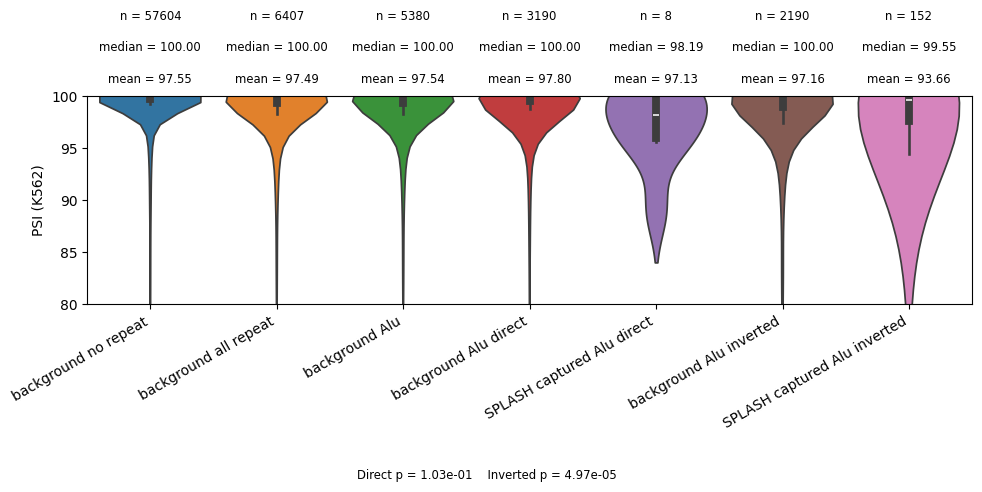

In [28]:
#Figure 1F

# 1. Column of interest
col = "PSI_K562"

# 2. Define data subsets

# (a) background no repeat
background_no_repeat = (
    alu_meta_ext.loc[alu_meta_ext["pair_type"] == "none", col]
    .dropna()
    .rename("background no repeat")
    .reset_index(drop=True)
)

# (b) background all repeat
background_all_repeat = (
    alu_meta_ext.loc[alu_meta_ext["pair_type"] != "none", col]
    .dropna()
    .rename("background all repeat")
    .reset_index(drop=True)
)

# (c) background Alu direct
background_Alu_direct = (
    alu_meta_ext.loc[
        (alu_meta_ext["type_meta"] == "Alu_pair") &
        (alu_meta_ext["pair_type"] == "direct"),
        col
    ]
    .dropna()
    .rename("background Alu direct")
    .reset_index(drop=True)
)

# (d) background Alu inverted
background_Alu_inverted = (
    alu_meta_ext.loc[
        (alu_meta_ext["type_meta"] == "Alu_pair") &
        (alu_meta_ext["pair_type"] == "inverted"),
        col
    ]
    .dropna()
    .rename("background Alu inverted")
    .reset_index(drop=True)
)

# (e) background Alu (union)
background_Alu = (
    pd.concat([background_Alu_direct, background_Alu_inverted], axis=0)
    .rename("background Alu")
    .reset_index(drop=True)
)

# (f) SPLASH captured Alu direct
SPLASH_captured_Alu_direct = (
    alu_meta_ext.loc[
        (alu_meta_ext["type_meta"] == "Alu_pair") &
        (alu_meta_ext["pair_type"] == "direct") &
        (alu_meta_ext["total_counts"] > 0),
        col
    ]
    .dropna()
    .rename("SPLASH captured Alu direct")
    .reset_index(drop=True)
)

# (g) SPLASH captured Alu inverted
SPLASH_captured_Alu_inverted = (
    alu_meta_ext.loc[
        (alu_meta_ext["type_meta"] == "Alu_pair") &
        (alu_meta_ext["pair_type"] == "inverted") &
        (alu_meta_ext["total_counts"] > 0),
        col
    ]
    .dropna()
    .rename("SPLASH captured Alu inverted")
    .reset_index(drop=True)
)

# 3. Concatenate in the desired order
out = pd.concat([
    background_no_repeat,
    background_all_repeat,
    background_Alu,
    background_Alu_direct,
    SPLASH_captured_Alu_direct,
    background_Alu_inverted,
    SPLASH_captured_Alu_inverted
], axis=1)

# 4. Create the violin plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(data=out, inner='box', ax=ax)

# 5. Annotate each violin with mean/median/n
max_val = np.nanmax(out.values)
for i, name in enumerate(out.columns):
    data = out[name].dropna()
    lines = [
        f"mean = {data.mean():.2f}",
        f"median = {data.median():.2f}",
        f"n = {len(data)}"
    ]
    for j, txt in enumerate(lines):
        ax.text(
            i,
            max_val * (1.01 + j * 0.03),
            txt,
            ha="center",
            va="bottom",
            size="small",
            color="black"
        )

# 6. Compute KS p‑values
bg_direct   = background_Alu_direct
sp_direct   = SPLASH_captured_Alu_direct
bg_inverted = background_Alu_inverted
sp_inverted = SPLASH_captured_Alu_inverted

pval_direct = (
    stats.ks_2samp(bg_direct, sp_direct)[1]
    if len(bg_direct) and len(sp_direct) else np.nan
)
pval_inverted = (
    stats.ks_2samp(bg_inverted, sp_inverted)[1]
    if len(bg_inverted) and len(sp_inverted) else np.nan
)

# 7. Final adjustments: leave room at bottom, add caption, save, show
plt.ylim(80, 100)
plt.xticks(rotation=30, ha="right")
plt.ylabel("PSI (K562)")

# carve out a 10% bottom margin for the caption
plt.tight_layout(rect=[0, 0.1, 1, 1])

# add the combined p‑value caption
fig.text(
    0.5, 0.04,
    f"Direct p = {pval_direct:.2e}    Inverted p = {pval_inverted:.2e}",
    ha="center",
    va="bottom",
    size="small",
    color="black"
)




In [3]:
%%R

library(cowplot)
library(png)


In [ ]:
%%R


fig1_1_img <- readPNG("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/figure_for_paper/Figure_1/fig1_1.PNG")
fig1_3_img <- readPNG("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/figure_for_paper/Figure_1/Fig1_3.PNG")
fig1_5_img <- readPNG("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/figure_for_paper/Figure_1/Fig1_5.PNG")
fig1_4_img <- readPNG("/home/blencowe/blencowe4/hlee/RNA_SS_Splicing/figure_for_paper/Figure_1/fig1_4.PNG")

fig1_1_grob <- rasterGrob(fig1_1_img, interpolate = TRUE)
fig1_3_grob <- rasterGrob(fig1_3_img, interpolate = TRUE)
fig1_5_grob <- rasterGrob(fig1_5_img, interpolate = TRUE)
fig1_4_grob <- rasterGrob(fig1_4_img, interpolate = TRUE)


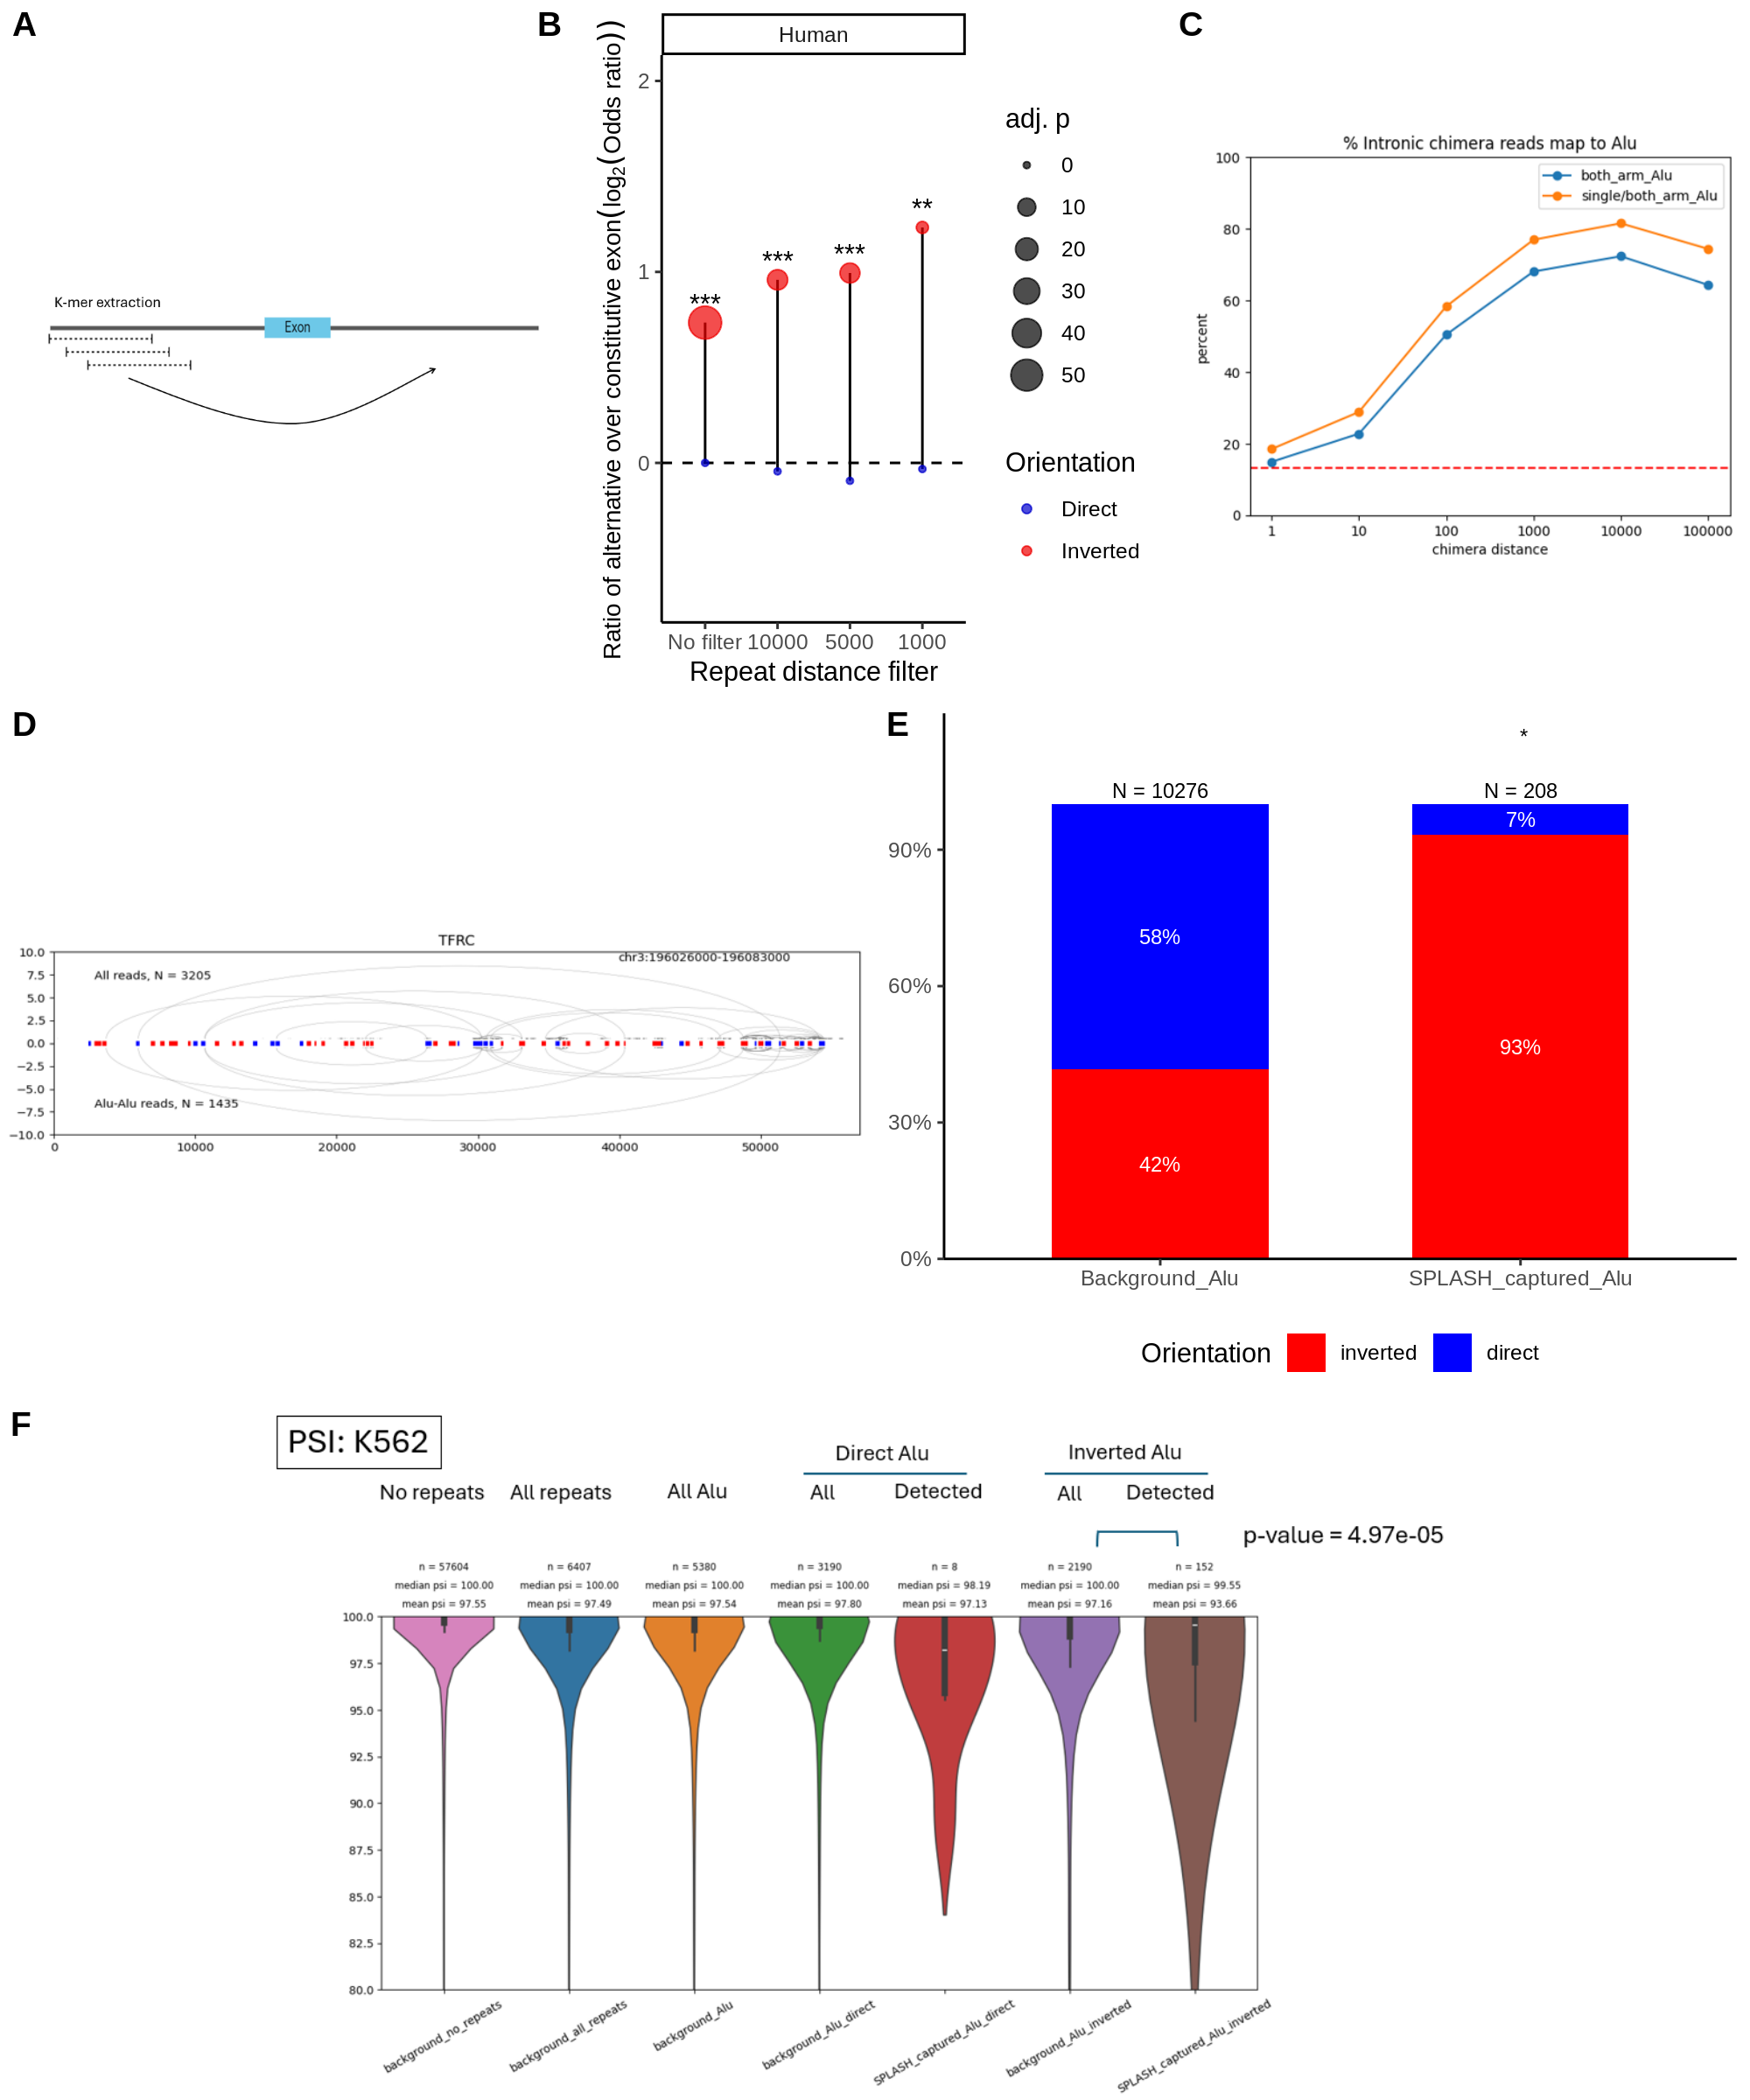

In [ ]:
%%R -w 10 -h 12 --units in -r 200

top_row <- plot_grid(
  fig1_1_grob, 
  human_plot, 
  fig1_3_grob, 
  ncol = 3,
  labels = c("A", "B", "C"),
  label_size = 14,
  label_fontface = "bold",
  label_x = c(0, -0.1, 0),  # Shift only the second label differently
  label_y = c(1, 1, 1)
)


middle_row <- plot_grid(
  fig1_4_grob, 
  SPLASH_enrichment, 
  ncol = 2, 
  labels = c("D", "E")
)

bottom_row <- plot_grid(
  fig1_5_grob, 
  ncol = 1, 
  labels = "F"
)

Fig1 <- plot_grid(
  top_row, 
  middle_row, 
  bottom_row, 
  ncol = 1
)

print(Fig1)
